### **PyTorch-YOLOv3를 구현해보겠습니다.**

- 깃허브 링크: https://github.com/eriklindernoren/PyTorch-YOLOv3
- PyTorch 로 구현한 YOLOv3 를 Colaboratory 에서 실행해보겠습니다.
- Coloaboratory 의 런타임 >> 런타임 유형변경에서 GPU 사용을 체크해야 합니다.

### **1. git clone으로 폴더 다운로드 하기**


In [1]:
!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3

Cloning into 'PyTorch-YOLOv3'...
remote: Enumerating objects: 1819, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1819 (delta 72), reused 64 (delta 24), pack-reused 1681
Receiving objects: 100% (1819/1819), 16.51 MiB | 32.03 MiB/s, done.
Resolving deltas: 100% (1082/1082), done.


- **git clone**은 클라이언트 상에 아무것도 없을 때 서버의 프로젝트를 내려받는 명령어입니다. 따라서 깃허브의 Pytorch-YOLOv3를 다운받겠다는 의미입니다.

### **2. 폴더 이동후 필요한 package 를 설치 하기**
- requirements.txt를 install 하려고 하는데 패키지들을 기록해놓을 수 있는 명령어인 **pip freeze**를 이용하여 먼저 설치를 합니다.
- 그 후 **pip freeze > requirements.txt** 명령어를 입력하면 requirements.txt 파일에 출력결과를 저장할 수 있습니다.

In [2]:
cd PyTorch-YOLOv3/

/content/PyTorch-YOLOv3


In [3]:
#!pip freeze

In [4]:
!pip freeze > requirements.txt

In [5]:
#!pip3 install -r requirements.txt

### **별도) 에러 발생 여부** 
- 제 컴퓨터에서는 별도의 에러가 뜨지 않았지만 에러가 뜬다면 다음과 같이 뜰 수도 있습니다.
- torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
- Pillow 버전이 맞지 않는 에러라고 하여 기존의 Pillow 를 uninstall 한 다음 최신으로 install 해줍니다.
 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip3 uninstall Pillow -y

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2


In [8]:
!pip3 install Pillow

     |████████████████████████████████| 4.3 MB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### **3. 이미 학습이 된 weight 를 다운로드**
- sh파일 안에 이미 학습을 시킨 weight를 다운 받는 명령어가 있으니 다운을 받습니다.
- sh파일 안은 cat 명령어를 이용하여 내용을 확인할 수 있습니다. **cat 명령어**는 파일 또는 표준 입력의 내용을 그대로 표준 출력에 출력하는 명령어입니다.


In [9]:
cd weights/

/content/PyTorch-YOLOv3/weights


In [10]:
!cat /content/PyTorch-YOLOv3/weights/download_weights.sh

#!/bin/bash
# Download weights for vanilla YOLOv3
wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com"
# # Download weights for tiny YOLOv3
wget -c "https://pjreddie.com/media/files/yolov3-tiny.weights" --header "Referer: pjreddie.com"
# Download weights for backbone network
wget -c "https://pjreddie.com/media/files/darknet53.conv.74" --header "Referer: pjreddie.com"


- 3가지의 weight를 다운받을 것입니다.
- vanilla YOLOv3와 tiny(매우작은) YOLOv3, backbone network인 darknet53 weights
- 우리가 YOLO를 직접 학습시킬수도 있지만 고성능 컴퓨터로 엄청난 시간에 걸쳐 학습을 시켜야 합니다. 따라서 이미 학습된 weight를 이용하여 이미지의 Detection을 시도해보겠습니다.

In [11]:
!bash download_weights.sh

--2022-02-19 17:33:02--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  59.4MB/s    in 4.3s    

2022-02-19 17:33:06 (55.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2022-02-19 17:33:06--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  38.5MB/s    in 0.9s    

2022-02-19 17:33:07 (38.5 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]

--202

### **4. 예측하기**
- 상위 폴더로 이동후 detect.py 파일을 실행하겠습니다.
- 경로 설정을 잘해주면 py 파일이 실행이 됩니다.

In [21]:
#!pip3 install poetry --user

In [13]:
cd /content/PyTorch-YOLOv3/pytorchyolo/

/content/PyTorch-YOLOv3/pytorchyolo


In [22]:
#!pip3 install pytorchyolo --user

In [15]:
cd /content/PyTorch-YOLOv3/

/content/PyTorch-YOLOv3


In [16]:
!python3 ./pytorchyolo/detect.py 

Environment information:
System: Linux 5.4.144+
Not using the poetry package
Current Commit Hash: 8f1c86d
Command line arguments: Namespace(batch_size=1, classes='data/coco.names', conf_thres=0.5, images='data/samples', img_size=416, model='config/yolov3.cfg', n_cpu=8, nms_thres=0.4, output='output', weights='weights/yolov3.weights')
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Detecting: 100% 9/9 [00:01<00:00,  5.17it/s]
Image data/samples/dog.jpg:
	+ Label: dog | Confidence: 0.9929
	+ Label: bicycle | Confidence: 0.9925
	+ Label: truck | Confidence: 0.9394
Image data/samples/eagle

- 기본 제공하는 sample 폴더 내용을 확인해보면 다음과 같은 예시 jpg가 있습니다.

In [17]:
ls -al /content/PyTorch-YOLOv3/data/samples/

total 1320
drwxr-xr-x 2 root root   4096 Feb 19 17:32 ./
drwxr-xr-x 4 root root   4096 Feb 19 17:32 ../
-rw-r--r-- 1 root root 163759 Feb 19 17:32 dog.jpg
-rw-r--r-- 1 root root 141886 Feb 19 17:32 eagle.jpg
-rw-r--r-- 1 root root 113880 Feb 19 17:32 field.jpg
-rw-r--r-- 1 root root 382965 Feb 19 17:32 giraffe.jpg
-rw-r--r-- 1 root root 133495 Feb 19 17:32 herd_of_horses.jpg
-rw-r--r-- 1 root root 126867 Feb 19 17:32 messi.jpg
-rw-r--r-- 1 root root  78771 Feb 19 17:32 person.jpg
-rw-r--r-- 1 root root  84988 Feb 19 17:32 room.jpg
-rw-r--r-- 1 root root 102770 Feb 19 17:32 street.jpg


- dog.jpg 파일을 가져와 실행해보겠습니다.

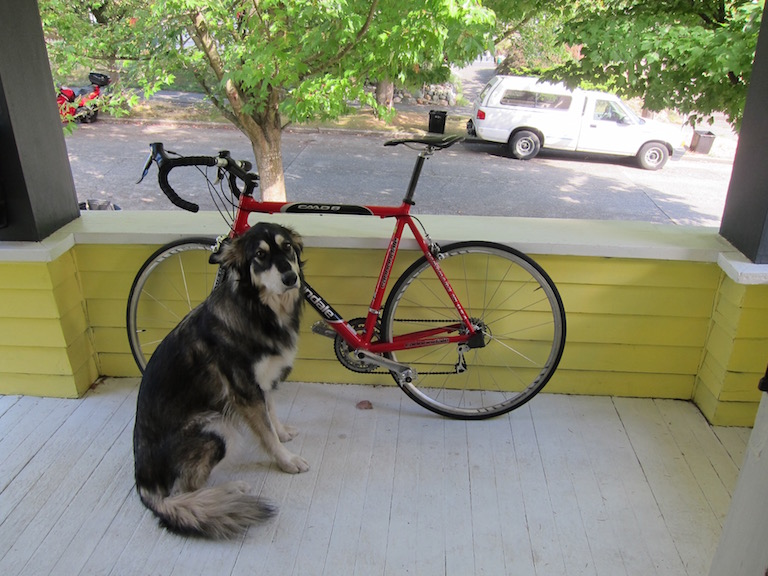

In [18]:
from IPython.display import Image
Image('/content/PyTorch-YOLOv3/data/samples/dog.jpg')

#### **YOLOv3가 예측하여 사각형을 그린 이미지를 확인해보겠습니다.**

In [19]:
ls -al /content/PyTorch-YOLOv3/output/

total 2588
drwxr-xr-x  2 root root   4096 Feb 19 17:34 ./
drwxr-xr-x 10 root root   4096 Feb 19 17:33 ../
-rw-r--r--  1 root root 328254 Feb 19 17:33 dog.png
-rw-r--r--  1 root root 305635 Feb 19 17:33 eagle.png
-rw-r--r--  1 root root 301200 Feb 19 17:33 field.png
-rw-r--r--  1 root root 381148 Feb 19 17:33 giraffe.png
-rw-r--r--  1 root root 268027 Feb 19 17:33 herd_of_horses.png
-rw-r--r--  1 root root 243348 Feb 19 17:33 messi.png
-rw-r--r--  1 root root 182940 Feb 19 17:34 person.png
-rw-r--r--  1 root root 313491 Feb 19 17:34 room.png
-rw-r--r--  1 root root 295405 Feb 19 17:34 street.png


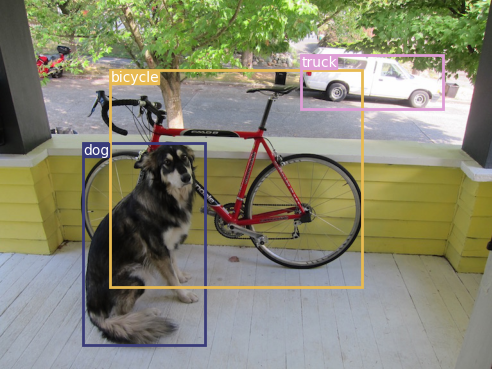

In [20]:
Image('/content/PyTorch-YOLOv3/output/dog.png')

### **[마무리]**

- 기존에 학습 되어있는 weight를 가져와서 이미지에 적용시켜보았습니다.
- 학습이 되어있기 때문에 weight만 가져오는거라 돌리는 시간은 얼마 걸리지 않았습니다. 하지만 darknet이나 전반적인 구조를 알기에는 힘든 감이 있지 않나 싶습니다.
- 다음 시간에는 backbone으로 사용된 darknet에 대하여 간단하게 구현을 해보겠습니다.

### **[Reference]**

[1] git 명령어 : https://www.zerocho.com/category/Git/post/581042fdcae2d100152ceae6

[2] 코드 : https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/PyTorch_YOLOv3.ipynb

